### Installing Libraries

In [9]:
from tensorflow import layers
from tensorflow import keras
import tensorflow as tf

from sklearn.model_selection import train_test_split

from ast import literal_eval
# is used for safely evaluating strings containing Python literals or container displays
# (e.g., lists, dictionaries) to their corresponding Python objects.

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [13]:
arxiv_data = pd.read_csv("../Datasets/arxiv_data_210930-054931.csv")

In [15]:
arxiv_data.head()

,terms,titles,abstracts
0,['cs.LG'],Multi-Level Attention Pooling for Graph Neural...,Graph neural networks (GNNs) have been widely ...
1,"['cs.LG', 'cs.AI']",Decision Forests vs. Deep Networks: Conceptual...,Deep networks and decision forests (such as ra...
2,"['cs.LG', 'cs.CR', 'stat.ML']",Power up! Robust Graph Convolutional Network v...,Graph convolutional networks (GCNs) are powerf...
3,"['cs.LG', 'cs.CR']",Releasing Graph Neural Networks with Different...,With the increasing popularity of Graph Neural...
4,['cs.LG'],Recurrence-Aware Long-Term Cognitive Network f...,Machine learning solutions for pattern classif...


### Data Cleaning and Preprocessing

In [16]:
arxiv_data.shape

(56181, 3)

In [17]:
arxiv_data.isnull().sum()

terms        0
titles       0
abstracts    0
dtype: int64

In [18]:
arxiv_data.duplicated().sum()

15054

In [19]:
# getting unique labels
labels_column = arxiv_data['terms'].apply(literal_eval)
labels = labels_column.explode().unique()
print("labels :",labels)
print("lenght :",len(labels))

labels : ['cs.LG' 'cs.AI' 'cs.CR' ... 'D.1.3; G.4; I.2.8; I.2.11; I.5.3; J.3'
 '68T07, 68T45, 68T10, 68T50, 68U35' 'I.2.0; G.3']
lenght : 1177


In [20]:
# remove duplicate entries based on the "titles" (terms) column
# This filters the DataFrame, keeping only the rows where the titles are not duplicated.
arxiv_data = arxiv_data[~arxiv_data['titles'].duplicated()]
print(f"There are {len(arxiv_data)} rows in the deduplicated dataset.")
# There are some terms with occurrence as low as 1.
print(sum(arxiv_data['terms'].value_counts()==1))
# how many unique terms
print(arxiv_data['terms'].nunique())

There are 41105 rows in the deduplicated dataset.
2503
3401


In [21]:
# Filtering the rare terms. (it keeps only those rows where the "terms" value occurs more than once in the original DataFrame.)
arxiv_data_filtered = arxiv_data.groupby('terms').filter(lambda x: len(x) > 1)
arxiv_data_filtered.shape

(38602, 3)

In [22]:
# It evaluates the given string containing a Python literal or container display (e.g., a list or dictionary) and returns the corresponding Python object.
arxiv_data_filtered['terms'] = arxiv_data_filtered['terms'].apply(lambda x: literal_eval(x))
arxiv_data_filtered['terms'].values[:3]

array([list(['cs.LG']), list(['cs.LG', 'cs.AI']),
       list(['cs.LG', 'cs.CR', 'stat.ML'])], dtype=object)

### Train and test split 


In [23]:
test_split = 0.1

# Initial train and test split.
# The stratify parameter ensures that the splitting is done in a way that preserves the same distribution of labels (terms) in both the training and test sets.
train_df, test_df = train_test_split(arxiv_data_filtered,test_size=test_split,stratify=arxiv_data_filtered["terms"].values,)

# Splitting the test set further into validation
# and new test sets.
val_df = test_df.sample(frac=0.5)
test_df.drop(val_df.index, inplace=True)

print(f"Number of rows in training set: {len(train_df)}")
print(f"Number of rows in validation set: {len(val_df)}")
print(f"Number of rows in test set: {len(test_df)}")

Number of rows in training set: 34741
Number of rows in validation set: 1930
Number of rows in test set: 1931


In [24]:
# creates a TensorFlow RaggedTensor (terms) from the values in the "terms" column of the train_df DataFrame. A RaggedTensor is a tensor with non-uniform shapes
terms = tf.ragged.constant(train_df['terms'].values)
# This line creates a StringLookup layer in TensorFlow. The purpose of this layer is to map strings to integer indices and vice versa. The output_mode="multi_hot" indicates that the layer will output a multi-hot encoded representation of the input strings.
lookup = tf.keras.layers.StringLookup(output_mode='multi_hot')
# This step adapts the StringLookup layer to the unique values in the "terms" column, building the vocabulary.
lookup.adapt(terms)
# retrieve vocabulary
vocab = lookup.get_vocabulary()

print("Vocabulary:\n")
print(vocab)

Vocabulary:

['[UNK]', 'cs.CV', 'cs.LG', 'stat.ML', 'cs.AI', 'eess.IV', 'cs.RO', 'cs.CL', 'cs.NE', 'cs.GR', 'cs.CR', 'math.OC', 'eess.SP', 'cs.SI', 'cs.MM', 'cs.SY', 'cs.IR', 'eess.SY', 'cs.MA', 'cs.HC', 'math.IT', 'cs.IT', 'cs.DC', 'stat.AP', 'cs.CY', 'stat.ME', 'stat.TH', 'math.ST', 'eess.AS', 'cs.SD', 'cs.DS', 'q-bio.QM', 'q-bio.NC', 'stat.CO', 'cs.CG', 'cs.NI', 'cs.GT', 'math.NA', 'cs.SE', 'cs.NA', 'I.2.6', 'physics.chem-ph', 'cs.DB', 'physics.comp-ph', 'cond-mat.dis-nn', 'q-bio.BM', 'cs.PL', 'cs.LO', 'math.PR', '68T45', 'cs.AR', 'physics.data-an', 'quant-ph', 'I.2.10', 'cs.CE', 'cond-mat.stat-mech', 'q-fin.ST', 'I.4.6', 'math.DS', 'cs.CC', '68T05', 'physics.soc-ph', 'physics.ao-ph', 'physics.med-ph', 'cs.PF', 'q-bio.GN', 'econ.EM', 'cs.DM', 'I.4.8', 'astro-ph.IM', 'physics.flu-dyn', 'math.AT', 'hep-ex', 'I.4', '68U10', 'q-fin.TR', 'physics.geo-ph', 'cs.FL', 'I.5.4', 'I.2', 'physics.optics', 'cond-mat.mtrl-sci', 'I.4.9', '68T10', 'q-fin.CP', 'I.4; I.5', '68T07', 'math.AP', 'I.2.6; 

In [25]:
sample_label = train_df["terms"].iloc[0]
print(f"Original label: {sample_label}")

label_binarized = lookup([sample_label])
print(f"Label-binarized representation: {label_binarized}")

Original label: ['cs.CV']
Label-binarized representation: [[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


In [26]:
# following lines::
# which is used for automatic adjustment of resource usage by TensorFlow's data loading pipeline.

#max_seqlen: Maximum sequence length. It indicates the maximum length allowed for sequences.
max_seqlen = 150
#batch_size: Batch size. It specifies the number of samples to use in each iteration.
batch_size = 128
#padding_token: A token used for padding sequences.
padding_token = "<pad>"
#auto = tf.data.AUTOTUNE: auto is assigned the value tf.data.AUTOTUNE,
auto = tf.data.AUTOTUNE

def make_dataset(dataframe, is_train=True):
    # creating sequences of labesls
    labels = tf.ragged.constant(dataframe["terms"].values)
    #This line uses the previously defined lookup layer to convert the ragged tensor of labels into a binarized representation. The resulting label_binarized is a NumPy array.
    label_binarized = lookup(labels).numpy()
    # creating sequences of text.
    dataset = tf.data.Dataset.from_tensor_slices((dataframe["abstracts"].values, label_binarized))
    # shuffling data basis on condition
    dataset = dataset.shuffle(batch_size * 10) if is_train else dataset
    return dataset.batch(batch_size)

"""
In summary, the make_dataset function is designed to create a 
dataset suitable for training a model. It takes a dataframe as input, 
assumes it has "abstracts" and "terms" columns, and creates a dataset of 
batches where each batch consists of abstract 
sequences and their corresponding binarized label sequences. 
"""

'\nIn summary, the make_dataset function is designed to create a \ndataset suitable for training a model. It takes a dataframe as input, \nassumes it has "abstracts" and "terms" columns, and creates a dataset of \nbatches where each batch consists of abstract \nsequences and their corresponding binarized label sequences. \n'

In [29]:
train_dataset = make_dataset(train_df, is_train=True)
validation_dataset = make_dataset(val_df, is_train=False)
test_dataset = make_dataset(test_df, is_train=False)

In [31]:
def decode_multi_hot(label, vocab):
    decoded_labels = [vocab[i] for i, val in enumerate(label) if val == 1]
    return decoded_labels

In [33]:

# Assuming you have already defined the terms and vocab variables

text_batch, label_batch = next(iter(train_dataset))

for i, text in enumerate(text_batch[:5]):
    label = label_batch[i].numpy()[None, ...]
    print(f"Abstract: {text}")
    decoded_labels = decode_multi_hot(label[0], vocab)
    print(f"Label(s): {decoded_labels}")
    print(" ")

Abstract: b'Single-image super-resolution (SR) and multi-frame SR are two ways to super\nresolve low-resolution images. Single-Image SR generally handles each image\nindependently, but ignores the temporal information implied in continuing\nframes. Multi-frame SR is able to model the temporal dependency via capturing\nmotion information. However, it relies on neighbouring frames which are not\nalways available in the real world. Meanwhile, slight camera shake easily\ncauses heavy motion blur on long-distance-shot low-resolution images. To\naddress these problems, a Blind Motion Deblurring Super-Reslution Networks,\nBMDSRNet, is proposed to learn dynamic spatio-temporal information from single\nstatic motion-blurred images. Motion-blurred images are the accumulation over\ntime during the exposure of cameras, while the proposed BMDSRNet learns the\nreverse process and uses three-streams to learn Bidirectional spatio-temporal\ninformation based on well designed reconstruction loss functio

In [34]:
# This code calculates the size of the vocabulary in the "abstracts" column of the train_df DataFrame.

# Creating vocabulary with uniques words
vocabulary = set()
train_df["abstracts"].str.lower().str.split().apply(vocabulary.update)
vocabulary_size = len(vocabulary)
print(vocabulary_size)

158883


### Text Vectorization

In [35]:
# Initializes a TextVectorization layer
text_vectorizer = layers.TextVectorization(max_tokens=vocabulary_size,ngrams=2,output_mode="tf_idf")
# `TextVectorization` layer needs to be adapted as per the vocabulary from our
# training set.
text_vectorizer.adapt(train_dataset.map(lambda text, label: text))

In [36]:
"""
Mapping Vectorization to Datasets: The code maps the text vectorization operation to 
each element of the training, validation, and test datasets. This ensures that the text
data in each dataset is transformed into numerical vectors using the adapted TextVectorization layer.
The num_parallel_calls parameter is used to parallelize the mapping process, and prefetch is 
applied to prefetch data batches 
for better performance.
"""
train_dataset = train_dataset.map(lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto).prefetch(auto)
validation_dataset = validation_dataset.map(lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto).prefetch(auto)
test_dataset = test_dataset.map(lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto).prefetch(auto)

### Model Training

In [37]:
# creating shallow_mlp_model  (MLP)
from tensorflow import EarlyStopping

# Creating shallow_mlp_model (MLP) with dropout layers
model1 = keras.Sequential([
    # First hidden layer: 512 neurons, ReLU activation function, with dropout.
    layers.Dense(512, activation="relu"),
    layers.Dropout(0.5),  # Adding dropout for regularization.

    # Second hidden layer: 256 neurons, ReLU activation function, with dropout.
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.5),  # Adding dropout for regularization.

    # Output layer: The number of neurons equals the vocabulary size (output vocabulary of the StringLookup layer), with a sigmoid activation function.
    layers.Dense(lookup.vocabulary_size(), activation='sigmoid')
])

In [38]:
# Compile the model
model1.compile(loss="binary_crossentropy", optimizer='adam', metrics=['binary_accuracy'])

In [39]:
# Add early stopping
# Number of epochs with no improvement after which training will be stopped.
# Restore weights from the epoch with the best value of the monitored quantity.
early_stopping = EarlyStopping(patience=5,restore_best_weights=True)

In [40]:
# Train the model
# Add early stopping callback.verbose=1
history = model1.fit(train_dataset,validation_data=validation_dataset,epochs=20,callbacks=[early_stopping])

Epoch 1/20
272/272 ━━━━━━━━━━━━━━━━━━━━ 544s 2s/step - binary_accuracy: 0.9508 - loss: 0.1180 - val_binary_accuracy: 0.9945 - val_loss: 0.0190
Epoch 2/20
272/272 ━━━━━━━━━━━━━━━━━━━━ 501s 2s/step - binary_accuracy: 0.9947 - loss: 0.0189 - val_binary_accuracy: 0.9946 - val_loss: 0.0185
Epoch 3/20
272/272 ━━━━━━━━━━━━━━━━━━━━ 524s 2s/step - binary_accuracy: 0.9957 - loss: 0.0142 - val_binary_accuracy: 0.9946 - val_loss: 0.0187
Epoch 4/20
272/272 ━━━━━━━━━━━━━━━━━━━━ 502s 2s/step - binary_accuracy: 0.9966 - loss: 0.0113 - val_binary_accuracy: 0.9945 - val_loss: 0.0195
Epoch 5/20
272/272 ━━━━━━━━━━━━━━━━━━━━ 505s 2s/step - binary_accuracy: 0.9971 - loss: 0.0098 - val_binary_accuracy: 0.9946 - val_loss: 0.0200
Epoch 6/20
272/272 ━━━━━━━━━━━━━━━━━━━━ 492s 2s/step - binary_accuracy: 0.9975 - loss: 0.0084 - val_binary_accuracy: 0.9945 - val_loss: 0.0201
Epoch 7/20
272/272 ━━━━━━━━━━━━━━━━━━━━ 487s 2s/step - binary_accuracy: 0.9977 - loss: 0.0078 - val_binary_accuracy: 0.9945 - val_loss: 0.0208

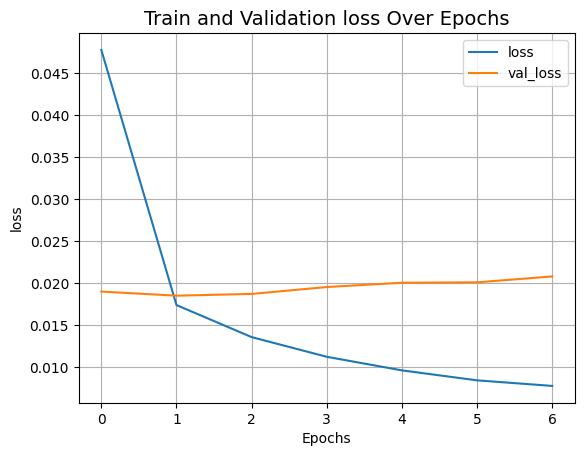

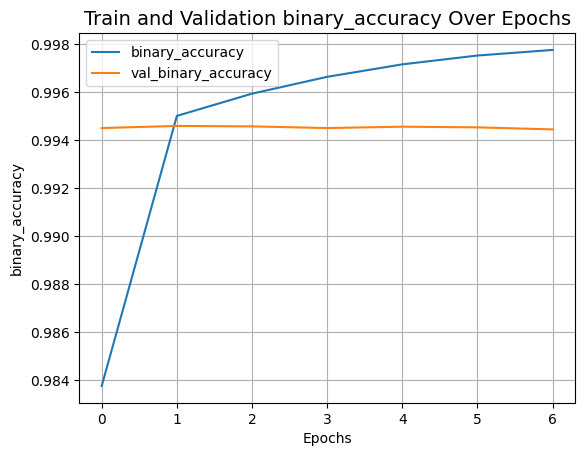

In [41]:
# plotting loss
def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_result("loss")
plot_result("binary_accuracy")

### Model Evaluation

In [42]:
# model evaltuation on test and val dataset
_, binary_acc1 = model1.evaluate(test_dataset)
_, binary_acc2 = model1.evaluate(validation_dataset)

print(f"Categorical accuracy on the test set: {round(binary_acc1 * 100, 2)}%.")
print(f"Categorical accuracy on the validation set: {round(binary_acc2 * 100, 2)}%.")

16/16 ━━━━━━━━━━━━━━━━━━━━ 16s 452ms/step - binary_accuracy: 0.9947 - loss: 0.0182
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 489ms/step - binary_accuracy: 0.9946 - loss: 0.0181
Categorical accuracy on the test set: 99.46%.
Categorical accuracy on the validation set: 99.46%.


In [52]:
import os

# Define the directory path
directory = "Models/"

# Create the directory if it doesn't exist
if not os.path.exists(directory):
    os.makedirs(directory)

In [102]:
import pickle

# Save the model in the recommended format
model1.save("Models/model.h5")

# Save the configuration of the text vectorizer
saved_text_vectorizer_config = text_vectorizer.get_config()
with open("Models/text_vectorizer_config.pkl", "wb") as f:
    pickle.dump(saved_text_vectorizer_config, f)

# Save the vocabulary
with open("Models/vocab.pkl", "wb") as f:
    pickle.dump(vocab, f)

### Text Vectorizer

In [103]:
from tensorflow import keras
import pickle

# Load the model
loaded_model = keras.models.load_model("Models/model.h5")

from tensorflow import TextVectorization

# Load the configuration of the text vectorizer
with open("Models/text_vectorizer_config.pkl", "rb") as f:
    saved_text_vectorizer_config = pickle.load(f)

# Create a new TextVectorization layer with the saved configuration
loaded_text_vectorizer = TextVectorization.from_config(saved_text_vectorizer_config)

# Load the saved weights into the new TextVectorization layer
# Save the weights of the TextVectorization layer
with open("Models/text_vectorizer_weights.pkl", "wb") as f:
    pickle.dump(loaded_text_vectorizer.get_weights(), f)

In [104]:
# Load the vocabulary
with open("Models/vocab.pkl", "rb") as f:
    loaded_vocab = pickle.load(f)

### Model Prediction

In [105]:
def invert_multi_hot(encoded_labels):
    """Reverse a single multi-hot encoded label to a tuple of vocab terms."""
    hot_indices = np.argwhere(encoded_labels == 1.0)[..., 0]
    return np.take(loaded_vocab, hot_indices)

### Model Prediction

In [106]:
def invert_multi_hot(encoded_labels):
    """Reverse a single multi-hot encoded label to a tuple of vocab terms."""
    hot_indices = np.argwhere(encoded_labels == 1.0)[..., 0]
    return np.take(loaded_vocab, hot_indices)

In [114]:
# Define the function to predict categories
def predict_category(abstract, model, vectorizer, label_lookup):
    # Preprocess the abstract using the loaded text vectorizer
    preprocessed_abstract = vectorizer([abstract])
    # Make predictions using the loaded model
    predictions = model.predict(preprocessed_abstract)
    # Post-process predictions
    predicted_labels = label_lookup(predictions)
    return predicted_labels


### Recommendation System

In [117]:
arxiv_data.drop(columns = ["terms","abstracts"], inplace = True)

In [118]:
arxiv_data.drop_duplicates(inplace= True)
arxiv_data.reset_index(drop= True,inplace = True)

In [119]:
pd.set_option('display.max_colwidth', None)
arxiv_data

,titles
0,Multi-Level Attention Pooling for Graph Neural Networks: Unifying Graph Representations with Multiple Localities
1,Decision Forests vs. Deep Networks: Conceptual Similarities and Empirical Differences at Small Sample Sizes
2,Power up! Robust Graph Convolutional Network via Graph Powering
3,Releasing Graph Neural Networks with Differential Privacy Guarantees
4,Recurrence-Aware Long-Term Cognitive Network for Explainable Pattern Classification
...,...
41100,An experimental study of graph-based semi-supervised classification with additional node information
41101,Bayesian Differential Privacy through Posterior Sampling
41102,Mining Spatio-temporal Data on Industrialization from Historical Registries
41103,Wav2Letter: an End-to-End ConvNet-based Speech Recognition System


### Sentence Transformers

In [1]:
%pip install -U -q sentence-transformers

Note: you may need to restart the kernel to use updated packages.


In [121]:
# This imports the SentenceTransformer class from the Sentence Transformers library.
from sentence_transformers import SentenceTransformer, util
# we load all-MiniLM-L6-v2, which is a MiniLM model fine tuned on a large dataset of over 
# 1 billion training pairs.
#This initializes the 'all-MiniLM-L6-v2' model from Sentence Transformers. 
# This model is capable of encoding sentences into fixed-size vectors (embeddings).
model = SentenceTransformer('all-MiniLM-L6-v2')
#Our sentences we like to encode
sentences = arxiv_data['titles']
#Sentences are encoded by calling model.encode()
embeddings = model.encode(sentences)

"""
The embeddings can be used for various natural language processing (NLP) tasks, 
such as similarity search, clustering
"""

c:\Users\rishm\Downloads\Project\env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'\nThe embeddings can be used for various natural language processing (NLP) tasks, \nsuch as similarity search, clustering\n'

In [122]:
embeddings

array([[ 0.06643406, -0.04954598,  0.06388083, ...,  0.00106303,
        -0.1215638 , -0.06962775],
       [ 0.09212255, -0.07606939,  0.06572866, ..., -0.08565161,
        -0.09266547,  0.00725295],
       [-0.0816268 ,  0.0242893 ,  0.01888748, ...,  0.0080616 ,
        -0.05129532, -0.05873994],
       ...,
       [ 0.01227978, -0.08568834, -0.02782773, ..., -0.0525798 ,
        -0.10806682,  0.07843316],
       [-0.07258196, -0.12690923, -0.00535554, ...,  0.03597706,
        -0.0398615 , -0.05971025],
       [ 0.0076887 , -0.10124182,  0.08909855, ..., -0.08199865,
        -0.05649744,  0.09007055]], dtype=float32)

### Print the embeddings

In [123]:
c = 0
#This loop iterates over pairs of sentences and their corresponding embeddings. 
#zip is used to iterate over both lists simultaneously.
for sentence, embedding in zip(sentences, embeddings):
    print("Sentence:", sentence)
    print("Embedding length:", len(embedding)) # list of floats
    print("")
    # Breaks out of the loop after printing information for the first 5 sentences.
    if c >=5:
        break
    c +=1 

Sentence: Multi-Level Attention Pooling for Graph Neural Networks: Unifying Graph Representations with Multiple Localities
Embedding length: 384

Sentence: Decision Forests vs. Deep Networks: Conceptual Similarities and Empirical Differences at Small Sample Sizes
Embedding length: 384

Sentence: Power up! Robust Graph Convolutional Network via Graph Powering
Embedding length: 384

Sentence: Releasing Graph Neural Networks with Differential Privacy Guarantees
Embedding length: 384

Sentence: Recurrence-Aware Long-Term Cognitive Network for Explainable Pattern Classification
Embedding length: 384

Sentence: Lifelong Graph Learning
Embedding length: 384



### Save Files

In [124]:
import pickle
# Saving sentences and corresponding embeddings
with open('Models/embeddings.pkl', 'wb') as f:
    pickle.dump(embeddings, f)

with open('Models/sentences.pkl', 'wb') as f:
    pickle.dump(sentences, f)
    
with open('Models/rec_model.pkl', 'wb') as f:
    pickle.dump(model, f)

### Recommendation for Similar Papers

In [126]:
# load save files
embeddings = pickle.load(open('Models/embeddings.pkl','rb'))
sentences = pickle.load(open('Models/sentences.pkl','rb'))
rec_model = pickle.load(open('Models/rec_model.pkl','rb'))

In [127]:
%pip install torch

In [128]:
import torch

def recommendation(input_paper):
    # Calculate cosine similarity scores between the embeddings of input_paper and all papers in the dataset.
    cosine_scores = util.cos_sim(embeddings, rec_model.encode(input_paper))
    
    # Get the indices of the top-k most similar papers based on cosine similarity.
    top_similar_papers = torch.topk(cosine_scores, dim=0, k=5, sorted=True)
                                 
    # Retrieve the titles of the top similar papers.
    papers_list = []
    for i in top_similar_papers.indices:
        papers_list.append(sentences[i.item()])
    
    return papers_list

In [130]:
# exampel usage 1: (use this paper as input (Attention is All you Need))
input_paper = input("Enter the title of any paper you like")
recommend_papers = recommendation(input_paper)


print("We recommend to read this paper............")
print("=============================================")
for paper in recommend_papers:
    print(paper)

We recommend to read this paper............
Multi-Level Attention Pooling for Graph Neural Networks: Unifying Graph Representations with Multiple Localities
PiNet: Attention Pooling for Graph Classification
Context-Aware Graph Attention Networks
Attention-driven Graph Clustering Network
Graph Attention Multi-Layer Perceptron
